In [1]:
import pandas as pd
import numpy as np
import math
from functools import reduce

In [2]:
dat = pd.read_csv('survey.csv', index_col=0)
CF = pd.read_csv('CF.csv', index_col=0) # Carbon footprint by activity and fuel source
CF.sort_index(inplace=True)
groups = pd.read_csv('Activity_groups.csv', index_col=0) # Activity groups
QLI = pd.read_csv('QLI.csv', index_col=0) # Individual quality of life
Cmp = pd.read_csv('Cmp.csv', index_col=0) # Individual consumption
CF_unit = pd.read_csv('CF_unit.csv', index_col=0) # CF per unit consumption by individual and activity

In [3]:
# List of activities and corresponding group
groups.sort_values('Activity', inplace=True)
nans = pd.DataFrame([(c, sum([math.isnan(a) for a in QLI[c]])) for c in QLI.columns], columns=["Activity", "QLI_Nans"])
groupSummary = groups.merge(nans, on='Activity')
#groupSummary.sort_values(['QLI_Nans', 'Group'], ascending=True)

## Quality of Life

In [4]:
# Impute missing data
# TODO: Impute missing data with a grouped cluster mean instead of removing entire column
#QLI.dropna(axis=1, inplace=True)
#nans = pd.DataFrame([(c, sum([math.isnan(a) for a in p[c]])) for c in p.columns], columns=["Activity", "Nans"])

# Normalize QLI
#QLI = (QLI - QLI.min()) / (QLI.max() - QLI.min()) # Normalize (0-1 scale)

### QLI by activity group

In [5]:
# Get the activities in each group
group_activities = [list(groups.Activity[groups.Group == ag]) for ag in range(1,7)]

QLIg = [QLI[gr_acts] for gr_acts in group_activities] #.dropna(axis=1)
#QLIg[0][:2]

## Consumption by Activity Group

In [6]:
# Get all sources used in the activities of each activity group
group_sources = [list(set([item for sublist in [list(CF.loc[i].dropna().index) for i in g] for item in sublist])) 
                 for g in group_activities]

# normalize
#Cmp_norm = (Cmp - Cmp.min()) / (Cmp.max() - Cmp.min()) # Normalize (0-1 scale)
Cmpg = [Cmp[list(groups.loc[groups.Group == g]['Activity'])] for g in range(1,7)]

Cmpg[0][:2]

,Household heating < 70F,Household heating => 70F,Use of air conditioner,Use of heat pump
Indnum,,,,
1,10.0,2.0,20.0,0.0
2,2.0,7.0,15.0,0.0


In [7]:
# Individual sources and consumption by activity group
currentSources_g = [reduce(lambda x, y: x.add(y, fill_value=0), 
                           [dat.loc[dat.Activity == activity][group_sources[0]].fillna(0).reset_index(drop=True)
                            for activity in gActs]) for gActs in group_activities]
Cmp_sources_g = []
for c, cmp in zip(currentSources_g, Cmpg):
    c['Indnum'] = c.index + 1
    csg = cmp.merge(c, left_on='Indnum', right_on='Indnum').drop('Indnum', axis=1)
    Cmp_sources_g.append(csg)

In [8]:
Cmp_sources_g[0][:2]

,Household heating < 70F,Household heating => 70F,Use of air conditioner,Use of heat pump,OP_e,peak_e,NG
0,10.0,2.0,20.0,0.0,0.0,0.0,2.0
1,2.0,7.0,15.0,0.0,0.0,0.0,2.0


In [9]:
group_sources

[['OP_e', 'peak_e', 'NG'],
 ['WH_gas', 'WH_peak_e', 'WH_solar', 'WH_OP_e'],
 ['OP_e', 'WH_gas', 'WH_OP_e', 'peak_e', 'WH_peak_e', 'WH_solar', 'NG'],
 ['OP_e', 'peak_e'],
 ['gas', 'OP_e', 'hybrid', 'jet_fuel', 'peak_e'],
 ['waste_mgmt']]

## Individual Carbon Footprint

In [10]:
# Individual Carbon Footprint for each activity
IndCF = Cmp * CF_unit
IndCF[:2]

,Household heating < 70F,Household heating => 70F,Small kitchen appliance in the home,TV/computer use,Use of air conditioner,Use of heat pump,air travel - large plane,air travel - small plane (<50 seats),bags of compost deposited (negative CF),bags of garbage disposed,...,shower - long (> 3 min),shower - short,trips using public ground transportation,use of oven,use of clothes dryer,use of clothes washer,use of cooking range,use of dishwasher,use of self-clean feature of electric oven,wash-up
Indnum,,,,,,,,,,,,,,,,,,,,,
1,0.008720,0.000872,0.0,0.000128,0.087010,0.0,0.491713,0.0,-0.1257,1.0894,...,0.009990,0.001077,0.004140,0.001404,0.000381,0.000195,0.0,0.0,0.000566,0.001848
2,0.001744,0.003052,0.0,0.000126,0.065257,0.0,0.451796,0.0,-0.0000,0.7123,...,0.004329,0.001508,0.003312,0.001200,0.000488,0.000780,0.0,0.0,0.000566,0.000176


In [11]:
# Create a summary of CF units by activity
# Use this to see room for improvement within each activity
CF_unit_summary = pd.DataFrame(list(CF.max(axis=1)), columns=['Max'], index=CF_unit.max().index)
CF_unit_summary['Min'] = list(CF.min(axis=1))
CF_unit_summary['Mean'] = list(CF_unit.mean())

In [12]:
IndCF.sum().sort_values(ascending=False)

bags of garbage disposed                          940.361700
air travel - large plane                          538.527049
car trips- self only                              197.631578
Use of air conditioner                             96.856519
large items disposed                               21.311000
car trips - driver and self                        14.033928
air travel - small  plane (<50 seats)              11.156760
shower - long (> 3 min)                             7.598916
Household heating < 70F                             4.820524
trips using public ground transportation            4.255644
car trips - 2+ people with multiple end points      3.175026
Household heating => 70F                            2.471765
wash-up                                             2.444820
hazardous or electric items disposed                1.582500
use of  oven                                        1.543032
shower - short                                      0.975409
use of clothes washer   

### All individuals - CF Improvement Potential

In [13]:
# For each individual -- total CF 
IndCFTot = IndCF.sum(axis=1)
# For each individual/activity -- how much can CF unit be improved
CFu_Improve = CF_unit - CF_unit_summary.Min
# For each individual/activity -- how much can CF be improved
CF_Improve = CFu_Improve * Cmp
# For each individual -- how much can CF be improved
IndCFTot_Improve = CF_Improve.sum(axis=1)

# Individual summary of CF and improvement potential
IndCF_sum = pd.DataFrame([(tot,improve) for tot,improve in zip(IndCFTot, IndCFTot_Improve)],
                         columns=['Current', 'Improve'], index = Cmp.index)
IndCF_sum['Possible'] = IndCF_sum.Current - IndCF_sum.Improve
IndCF_sum['Pct_change'] = IndCF_sum.Improve / IndCF_sum.Current
IndCF_sum[:4]

,Current,Improve,Possible,Pct_change
Indnum,,,,
1,1.882629,0.263196,1.619433,0.139802
2,1.413601,0.172593,1.241008,0.122095
3,1.649389,0.175930,1.473459,0.106664
4,2.043124,0.204667,1.838457,0.100174


In [14]:
# IndCF by activity group
# TODO

In [15]:
topIndCFs = [_.sort_values(ascending=False)[_ > 0.01] for i,_ in IndCF.iterrows()]

In [16]:
pd.DataFrame(topIndCFs)[:3]

,bags of garbage disposed,air travel - large plane,car trips- self only,Use of air conditioner,large items disposed,car trips - driver and self,shower - long (> 3 min),hazardous or electric items disposed,car trips - 2+ people with multiple end points,air travel - small plane (<50 seats)
1,1.0894,0.491713,0.244093,0.087010,0.0422,0.021052,NaN,NaN,NaN,NaN
2,0.7123,0.451796,0.150423,0.065257,NaN,0.010526,NaN,NaN,NaN,NaN
3,0.9218,0.474887,0.143260,0.069608,NaN,0.019390,NaN,NaN,NaN,NaN


### Prep data for analysis

In [17]:
# Clean up activity names
oldActs = list(QLI.columns)
newActNames = ['heat_cool', 'heat_hot', 'kitchen_appliance_sm', 'TV_computer_use', 'AC_use', 'heat_pump_use', 'travel_plane_lg', 'travel_plane_sm', 'compost_bags', 'garbage_bags', 'recycling_bags', 'bath', 'drive_HOV', 'drive_2', 'drive_self', 'hzd_disposals', 'lg_item_disposals', 'shower_long', 'shower_short', 'public_trans_trips', 'use_oven', 'use_dryer', 'use_washer', 'use_cooking_range', 'use_dishwasher', 'use_self_clean_e_oven', 'wash_up']
activities = dict(zip(oldActs, newActNames))

QLI.rename(columns=activities, inplace=True)
Cmp.rename(columns=activities, inplace=True)
CF_unit.rename(columns=activities, inplace=True)
IndCF.rename(columns=activities, inplace=True)

CF.sort_index(inplace=True)
CF.rename(index=activities, inplace=True)

In [18]:
for i in range(len(Cmpg)):
    Cmpg[i].rename(columns=activities, inplace=True)
    QLIg[i].rename(columns=activities, inplace=True)

C:\Users\sc1692.8.29.18\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [19]:
QLI.columns

Index(['heat_cool', 'heat_hot', 'kitchen_appliance_sm', 'TV_computer_use',
       'AC_use', 'heat_pump_use', 'travel_plane_lg', 'travel_plane_sm',
       'compost_bags', 'garbage_bags', 'recycling_bags', 'bath', 'drive_HOV',
       'drive_2', 'drive_self', 'hzd_disposals', 'lg_item_disposals',
       'shower_long', 'shower_short', 'public_trans_trips', 'use_oven',
       'use_dryer', 'use_washer', 'use_cooking_range', 'use_dishwasher',
       'use_self_clean_e_oven', 'wash_up'],
      dtype='object')

## Activity models

In [24]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [20]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', c='Red')

In [21]:
def getActivityData(name):
    df = pd.DataFrame(index = QLI.index, columns = ['QLI', 'Cmp', 'CF_unit'])
    df.name = name
    df.QLI = QLI[name]
    df.Cmp = Cmp[name]
    df.CF_unit = CF_unit[name]
    return df

In [39]:
def plot_reg(df, x = 'Cmp', y = 'QLI'):
    plt.scatter(x=df.Cmp, y=df.QLI) #, c=heating.group, alpha=0.75)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(df.name)
    coefs = np.polyfit(df[x], df[y], deg=1, full=True)
    bs = coefs[0]
    abline(bs[0], bs[1])
    return bs

b1:  -0.02037888162499711


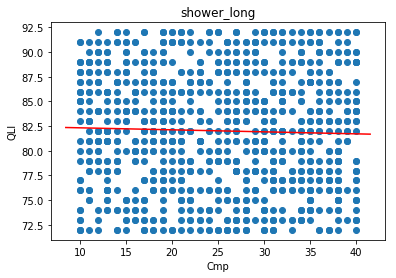

In [40]:
heat1 = getActivityData('shower_long')
bs = plot_reg(heat1)
print("b1: ", bs[0])

In [38]:
bs[0]


array([-2.03788816e-02,  8.25350701e+01])

## Air Conditioning -- Develop mathematical model

In [75]:
AC = pd.DataFrame(index = QLI.index, columns = ['QLI', 'Cmp', 'CF_unit'])
AC.QLI = QLI.AC_use
AC.Cmp = Cmp.AC_use
AC.CF_unit = CF_unit.AC_use
bs = np.polyfit(AC.Cmp, AC.QLI, deg=1)

,QLI,Cmp,CF_unit
Indnum,,,
1,45.0,20.0,0.00435
2,57.0,15.0,0.00435
3,52.0,16.0,0.00435
4,47.0,18.0,0.00435


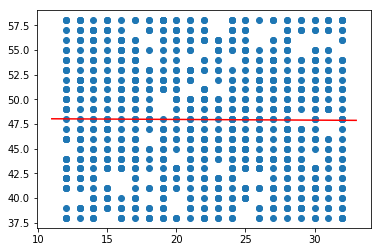

In [134]:
plt.scatter(x=AC.Cmp, y=AC.QLI) #, c=heating.group, alpha=0.75)
abline(bs[0], bs[1])

### Organize data into people classes

In [103]:
from collections import namedtuple

In [105]:
sourceNames = dat.columns[6:]
sources = [dat.pivot(index='Indnum', columns='Activity', values=i).rename(columns=activities)
          for i in sourceNames]
sources[0][:2]

Activity,heat_cool,heat_hot,kitchen_appliance_sm,TV_computer_use,AC_use,heat_pump_use,travel_plane_lg,travel_plane_sm,compost_bags,garbage_bags,...,shower_long,shower_short,public_trans_trips,use_oven,use_dryer,use_washer,use_cooking_range,use_dishwasher,use_self_clean_e_oven,wash_up
Indnum,,,,,,,,,,,,,,,,,,,,,
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [106]:
len(sources)

11

In [593]:
# People
class Person:
    def __init__(self, Indnum):
        self.num = Indnum
        self.qli = Importance(*[q for q in QLI.loc[Indnum]])
        self.cmp = Consumption(*[c for c in Cmp.loc[Indnum]])
        self.cf_unit = Unit_Footprint(*[u for u in CF_unit.loc[Indnum]])
        self.cf = Footprint(*[f for f in IndCF.loc[Indnum]])
        self.df = None
        self.summary = self.populateSummary()
        
    def populateSummary(self):
        s = [round(cf,4) for cf in IndCF_sum.loc[self.num]]
        s[3] = str(s[3] * 100) + '%'
        return Summary(*s)
    
    def displaySummary(self):
        for _,s in enumerate(self.summary):
            print(self.summary._fields[_]+":", s)
    
    def viewFrame(self):
        if self.df == None:
            self.getFrame()
        return self.df
        
    def getFrame(self):
        self.df = pd.DataFrame(list(self.qli), index = newActNames, columns=['QLI'])
        self.df['Cmp'] = list(self.cmp)
        self.df['CF_Unit'] = list(self.cf_unit)
        self.df['CF'] = list(self.cf)
        self.df['grp'] = list(groups.Group)
        # How much can the CF unit be improved
        self.df['CFu_Improve'] = self.df.CF_Unit - CF_unit_summary.Min
        self.df['CF_Improve'] = self.df.CFu_Improve * self.df.Cmp
        self.df['CF_Improve_Pct'] = self.df.CF_Improve / self.df.CF # Change / Current CF
        self.df.fillna(0, inplace=True)
        
    def getFrameSources(self):
        for i in range(len(sourceNames)):
            self.df[sourceNames[i]] = sources[i].loc[self.num]
        self.df.dropna(axis=1, how='all', inplace=True)
        return self.df
    
    def viewGroup(self, group):
        #if self.df == None:
            #self.getFrame()
        g = self.df[self.df.grp == group].copy()
        g.dropna(axis=1, how='all', inplace=True)
        return g
    
    #def viewPlot(self):
        
        
Consumption = namedtuple('Consumption', newActNames)
Importance = namedtuple('Importance', newActNames)
Unit_Footprint = namedtuple('Footprint', newActNames)
Footprint = namedtuple('Footprint', newActNames)
summary_elems = ['CF_Current', 'Possible_Improvement', 'CF_Possible', 'Pct_Change_Possible']
Summary = namedtuple('Summary', summary_elems)

In [594]:
p1 = Person(1)
df = p1.viewFrame()
#p1.viewGroup(5)

In [595]:
p1.displaySummary()

CF_Current: 1.8826
Possible_Improvement: 0.2632
CF_Possible: 1.6194
Pct_Change_Possible: 13.98%


In [612]:
# Metric: CF / QLI -- want to minimize this!
#df['CF_per_QLI'] = df.CF / df.QLI
#df

In [614]:
df.sort_values('CF', ascending=False)[:10]

,QLI,Cmp,CF_Unit,CF,grp,CFu_Improve,CF_Improve,CF_Improve_Pct,Label
garbage_bags,41.0,26.00,0.041900,1.089400,6,0.000000,0.000000,0.000000,Best CF Unit
travel_plane_lg,42.0,27.47,0.017900,0.491713,5,0.000000,0.000000,0.000000,Best CF Unit
drive_self,44.0,443.00,0.000551,0.244093,5,0.000359,0.159037,0.651543,Can Improve
AC_use,45.0,20.00,0.004350,0.087010,1,0.003752,0.075050,0.862545,Can Improve
lg_item_disposals,15.0,2.00,0.021100,0.042200,6,0.000000,0.000000,0.000000,Best CF Unit
drive_2,27.0,38.00,0.000554,0.021052,5,0.000355,0.013490,0.640794,Can Improve
shower_long,74.0,30.00,0.000333,0.009990,2,0.000316,0.009480,0.948949,Can Improve
heat_cool,85.0,10.00,0.000872,0.008720,1,0.000000,0.000000,0.000000,Best CF Unit
public_trans_trips,49.0,15.00,0.000276,0.004140,5,0.000000,0.000000,0.000000,Best CF Unit
drive_HOV,0.0,10.00,0.000354,0.003540,5,0.000322,0.003220,0.909605,Can Improve


### Visualizing Individual

In [616]:
df['Label'] = ["Best CF Unit" if i == 0 else "Can Improve" for i in df.CF_Improve_Pct]
g = df.groupby('Label')

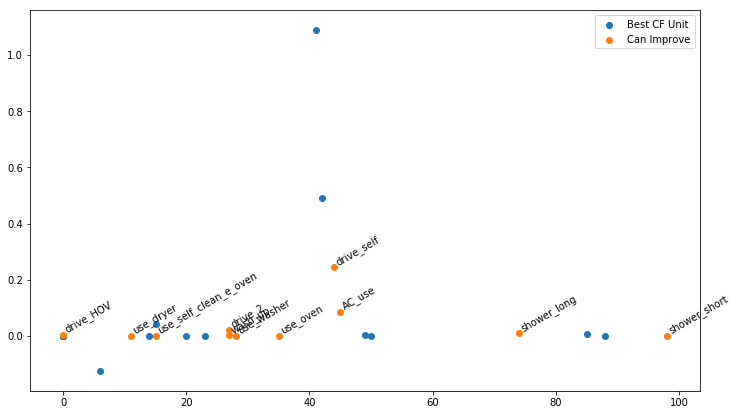

In [638]:
fig, ax = plt.subplots(figsize=(12,7))
for name, group in g:
    ax.scatter(group.QLI, group.CF, label=name)
ax.legend()

for i, txt in enumerate(df.index):
    if df.CF_Improve_Pct[i] > 0:
        ax.annotate(txt, (df.QLI[i], df.CF[i]), rotation = 30, ha='left', va='bottom')

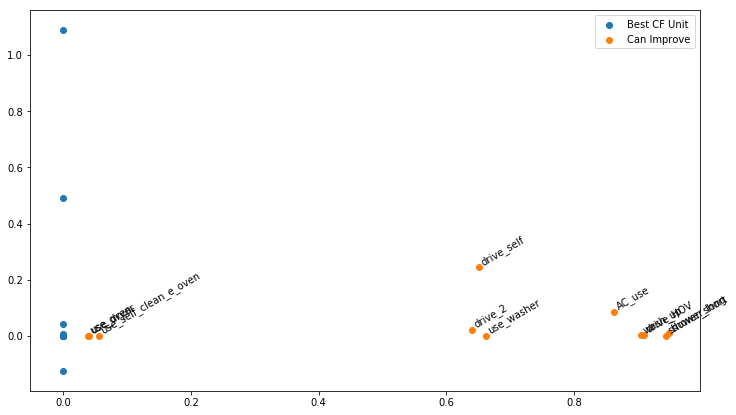

In [643]:
fig, ax = plt.subplots(figsize=(12,7))
for name, group in g:
    ax.scatter(group.CF_Improve_Pct, group.CF, label=name)
ax.legend()

for i, txt in enumerate(df.index):
    if df.CF_Improve_Pct[i] > 0:
        ax.annotate(txt, (df.CF_Improve_Pct[i], df.CF[i]), rotation = 30, ha='left', va='bottom')

## Carbon Footprints and Improvement Potential by activity

In [653]:
#IndCF
CF_Improve_Pct = CF_Improve.divide(IndCF)

In [656]:
IndCF.AC_use[:2]

Indnum
1    0.087010
2    0.065257
Name: AC_use, dtype: float64

In [657]:
CF_Improve.AC_use[:2]

Indnum
1    0.075050
2    0.056287
Name: AC_use, dtype: float64

In [654]:
CF_Improve_Pct

,heat_cool,heat_hot,kitchen_appliance_sm,TV_computer_use,AC_use,heat_pump_use,travel_plane_lg,travel_plane_sm,compost_bags,garbage_bags,...,shower_long,shower_short,public_trans_trips,use_oven,use_dryer,use_washer,use_cooking_range,use_dishwasher,use_self_clean_e_oven,wash_up
Indnum,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,NaN,0.0,0.862545,NaN,0.0,NaN,-0.0,0.0,...,0.948949,0.944316,0.0,0.038462,0.03937,0.661538,NaN,NaN,0.055703,0.904762
2,0.000000,0.000000,NaN,0.0,0.862545,NaN,0.0,NaN,NaN,0.0,...,0.948949,0.944316,0.0,0.000000,0.00000,0.661538,NaN,NaN,0.055703,0.000000
3,0.000000,0.000000,NaN,0.0,0.862545,NaN,0.0,NaN,NaN,0.0,...,0.000000,0.944316,0.0,0.038462,0.03937,0.661538,NaN,NaN,0.055703,0.826087
4,0.000000,0.000000,NaN,0.0,0.862545,NaN,0.0,NaN,NaN,0.0,...,0.948949,0.944316,0.0,0.000000,0.00000,0.661538,NaN,NaN,0.055703,0.904762
5,0.000000,0.000000,NaN,0.0,0.862545,NaN,0.0,NaN,NaN,0.0,...,0.948949,0.944316,0.0,0.038462,0.03937,0.511111,NaN,NaN,0.055703,0.934426
6,0.000000,0.000000,0.136842,0.0,0.862545,NaN,0.0,NaN,NaN,0.0,...,0.948949,0.944316,0.0,0.000000,0.03937,0.661538,NaN,0.691358,0.055703,0.934426
7,0.000000,0.000000,NaN,0.0,0.862545,NaN,0.0,NaN,NaN,0.0,...,0.948949,0.944316,0.0,0.038462,0.03937,0.834171,0.025271,NaN,0.055703,0.826087
8,0.000000,0.000000,NaN,0.0,0.862545,NaN,0.0,NaN,NaN,0.0,...,0.948949,0.944316,0.0,0.000000,0.00000,0.661538,NaN,NaN,0.055703,0.934426
9,0.028412,0.000000,NaN,0.0,0.862545,NaN,0.0,NaN,NaN,0.0,...,0.948949,0.944316,0.0,0.038462,0.03937,0.661538,NaN,NaN,0.055703,0.934426


## Visualize QLI by activity group

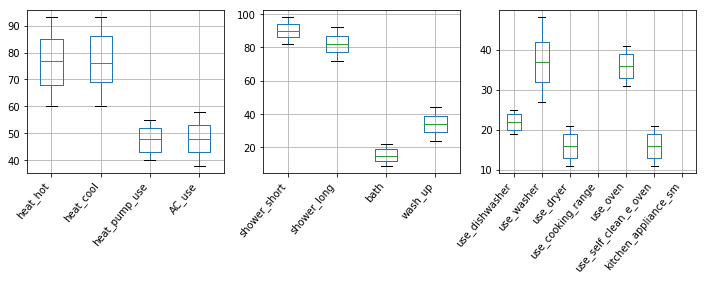

In [81]:
%matplotlib inline
fig, axs = plt.subplots(1,3, figsize=(12,3))
for i in range(3):
    g = QLIg[i]
    f = g.boxplot(ax=axs[i]).set_xticklabels(g.columns, rotation=50, ha="right")

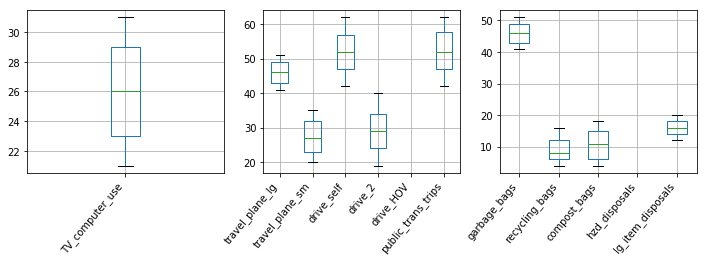

In [82]:
%matplotlib inline
fig, axs = plt.subplots(1,3, figsize=(12,3))
for i in range(3):
    g = QLIg[i+3]
    f = g.boxplot(ax=axs[i]).set_xticklabels(g.columns, rotation=50, ha="right")

In [164]:
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.neighbors import BallTree
from sklearn.utils import extmath
from sklearn.metrics.pairwise import euclidean_distances
from collections import defaultdict

### Explore Heating QLI and Consumption

In [165]:
heating = QLI[['heat_cool', 'heat_hot']].merge(Cmp[['heat_cool', 'heat_hot']], on='Indnum')
heating.columns = ['QLI_cool', 'QLI_hot', 'Cmp_cool', 'Cmp_hot']
heating[:2]

,QLI_cool,QLI_hot,Cmp_cool,Cmp_hot
Indnum,,,,
1,85.0,88.0,10.0,2.0
2,61.0,77.0,2.0,7.0


In [166]:
heating.count()

QLI_cool    1002
QLI_hot     1002
Cmp_cool    1002
Cmp_hot     1002
dtype: int64

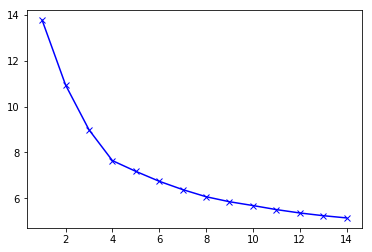

In [167]:
errors = []
K = range(1,15)
for k in K:
    kmeans = KMeans(n_clusters = k).fit(heating)
    errors.append(sum(np.min(cdist(heating, kmeans.cluster_centers_, 'euclidean'), axis=1)) / heating.shape[0])
plt.plot(K, errors, 'bx-')

In [168]:
kmeans = KMeans(n_clusters = 8).fit(heating)
heating['group'] = kmeans.labels_

Text(0.5,0,'Heating < 70')

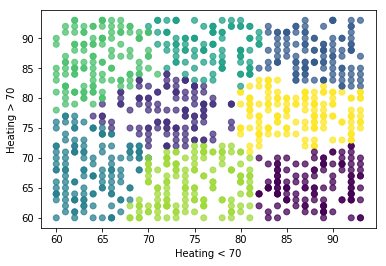

In [169]:
plt.scatter(x=heating.QLI_cool, y=heating.QLI_hot, c=heating.group, alpha=0.75)
plt.ylabel('Heating > 70')
plt.xlabel('Heating < 70')

In [163]:
# Metric to identify people to recommend a reduction of heating use

In [132]:
heating[:2]

,QLI_cool,QLI_hot,Cmp_cool,Cmp_hot,group
Indnum,,,,,
1,85.0,88.0,10.0,2.0,5
2,61.0,77.0,2.0,7.0,2


In [140]:
heatingNorm = (heating - heating.min()) / (heating.max() - heating.min())
heating['Rec'] = (1-heatingNorm.QLI_hot) * heatingNorm.Cmp_hot
heating.sort_values('Rec', ascending=False)[:2]

,QLI_cool,QLI_hot,Cmp_cool,Cmp_hot,group,Rec
Indnum,,,,,,
629,66.0,62.0,8.0,10.0,6,0.939394
129,75.0,63.0,7.0,10.0,6,0.909091


## Recommendation

In [188]:
rec = ["" for i in QLI.index]
for _,i in heating.iterrows():
    prefer_hot = i[1] / i[0]
    use_hot = i[3] / i[2]
    # lower thermostat should't hurt QLI if
    # <70 is more or as important than >70,
    # use more or similar hot than cool heat
    # QLI for hot isn't super high
    if prefer_hot <= 1 and i[1] < 80 and use_hot > 0.75:
        rec[_-1] = rec[_-1] + "Lower your thermostat! "

In [193]:
heating['recommendations'] = rec
heating.sort_values('QLI_hot', ascending=False)[420:440]

,QLI_cool,QLI_hot,Cmp_cool,Cmp_hot,group,Rec,recommendations
Indnum,,,,,,,
486,81.0,79.0,2.0,5.0,1,0.188552,Lower your thermostat!
765,76.0,79.0,3.0,3.0,7,0.094276,
84,64.0,79.0,4.0,3.0,0,0.094276,
697,77.0,79.0,3.0,8.0,7,0.329966,
289,85.0,79.0,7.0,10.0,1,0.424242,Lower your thermostat!
834,88.0,79.0,1.0,9.0,1,0.377104,Lower your thermostat!
277,65.0,79.0,2.0,10.0,0,0.424242,
531,87.0,79.0,4.0,1.0,1,0.000000,
108,67.0,79.0,7.0,5.0,0,0.188552,


In [190]:
heating.groupby('recommendations').count()

,QLI_cool,QLI_hot,Cmp_cool,Cmp_hot,group,Rec
recommendations,,,,,,
,721,721,721,721,721,721
Lower your thermostat!,281,281,281,281,281,281


In [196]:
QLI.columns

Index(['heat_cool', 'heat_hot', 'kitchen_appliance_sm', 'TV_computer_use',
       'AC_use', 'heat_pump_use', 'travel_plane_lg', 'travel_plane_sm',
       'compost_bags', 'garbage_bags', 'recycling_bags', 'bath', 'drive_HOV',
       'drive_2', 'drive_self', 'hzd_disposals', 'lg_item_disposals',
       'shower_long', 'shower_short', 'public_trans_trips', 'use_oven',
       'use_dryer', 'use_washer', 'use_cooking_range', 'use_dishwasher',
       'use_self_clean_e_oven', 'wash_up'],
      dtype='object')

In [199]:
groups

,Group,Activity
0,1,Household heating => 70F
1,1,Household heating < 70F
2,1,Use of heat pump
3,1,Use of air conditioner
4,2,shower - short
5,2,shower - long (> 3 min)
6,2,bath
7,2,wash-up
8,3,use of dishwasher
9,3,use of clothes washer


## MeanShift Clustering

In [ ]:
g = QLIg[0].copy() # Focusing on QLI for activity group 1 here

In [176]:
bandwidth

11.927610052865507

In [177]:
bandwidth = estimate_bandwidth(g, quantile=0.1, n_samples=len(g))

msh = MeanShift(bandwidth=bandwidth, seeds=[np.array(i) for _,i in clusters.iterrows()]) # bin_seeding=True
msh.fit(g)

MeanShift(bandwidth=11.545969913486568, bin_seeding=False, cluster_all=True,
     min_bin_freq=1, n_jobs=1,
     seeds=[array([76.32967, 79.07692, 47.79121, 41.95604]), array([81.67241, 88.01724, 47.2931 , 52.78448]), array([87.45714, 68.18095, 46.78095, 42.44762]), array([64.38158, 83.25   , 47.39474, 42.71053]), array([66.95098, 87.90196, 47.14706, 51.84314]), array([84.77907, 75.69767, 48.60465, 54.25581]), array([87.71717, 86.29293, 47.79798, 43.45455]), array([67.09565, 65.44348, 49.03478, 43.64348]), array([82.12222, 64.55556, 46.26667, 52.28889]), array([67.30328, 70.95902, 47.52459, 52.64754])])

In [178]:
bandwidth

11.545969913486568

In [179]:
centers = msh.cluster_centers_
len(centers)

4

In [180]:
g['labels'] = msh.labels_

In [181]:
#g.groupby('labels').count()
centers

array([[67.74038462, 69.01923077, 48.25480769, 47.82692308],
       [82.60869565, 85.90821256, 47.85990338, 49.352657  ],
       [67.11052632, 83.60526316, 47.03684211, 47.62105263],
       [81.59016393, 68.59562842, 46.57923497, 49.37704918]])

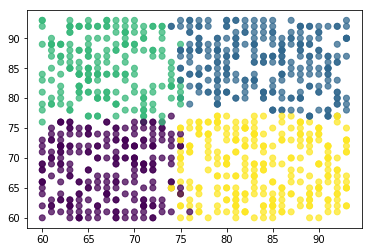

In [186]:
# ** Results of Meanshift clustering on all of activity group 1
plt.scatter(g['Household heating => 70F'], g['Household heating < 70F'], c=g.labels, alpha=0.75)

## K Means Clustering -- QLI

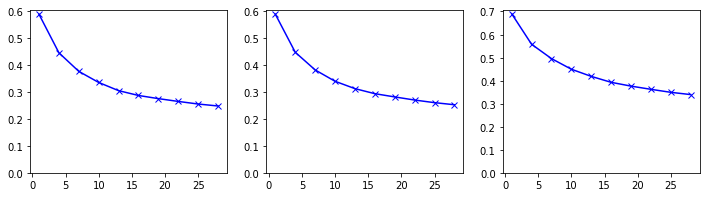

In [33]:
fig, axs = plt.subplots(1,3, figsize=(12,3))
K = [i * 3 + 1 for i in range(0,10)]
for i,g in enumerate(QLIg[:3]):
    g = g.dropna(axis=1)
    errors = []
    for j in K:
        kmeans = KMeans(n_clusters = j).fit(g)
        errors.append(sum(np.min(cdist(g, kmeans.cluster_centers_, 'euclidean'), axis=1)) / g.shape[0])
    axs[i].plot(K, errors, 'bx-')
    axs[i].set_ylim(bottom = 0)

In [322]:
# QLI clustering for activity group 1 
k = 10
g = QLIg[0].copy()
errors = [] # Track errors 
k_seeds = [1,18,42,99,76] # Determine random seed that doesn't fall into a local minimum
for rs in k_seeds:
    kmeans = KMeans(n_clusters=k, random_state = rs).fit(g)
    errors.append(sum(np.min(cdist(g, kmeans.cluster_centers_, 'euclidean'), axis=1)) / g.shape[0])

In [323]:
[i == np.min(errors) for i in errors] # Choose 18

[False, True, False, False, False]

In [149]:
kmeans = KMeans(n_clusters=10, random_state = 18).fit(g)
clusters = pd.DataFrame(kmeans.cluster_centers_, columns=g.columns)
clusters

,Household heating => 70F,Household heating < 70F,Use of heat pump,Use of air conditioner
0,76.329670,79.076923,47.791209,41.956044
1,81.672414,88.017241,47.293103,52.784483
2,87.457143,68.180952,46.780952,42.447619
3,64.381579,83.250000,47.394737,42.710526
4,66.950980,87.901961,47.147059,51.843137
5,84.779070,75.697674,48.604651,54.255814
6,87.717172,86.292929,47.797980,43.454545
7,67.095652,65.443478,49.034783,43.643478
8,82.122222,64.555556,46.266667,52.288889
9,67.303279,70.959016,47.524590,52.647541


In [ ]:
QLIg[0]['Group'] = kmeans.predict(g)

C:\Users\sc1692.8.29.18\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


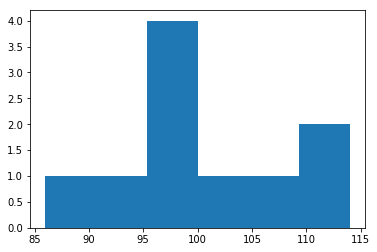

In [122]:
# Check that the clusters are evenly sized
h1 = plt.hist(QLIg[0].groupby('Group').count().mean(axis=1).values,6)

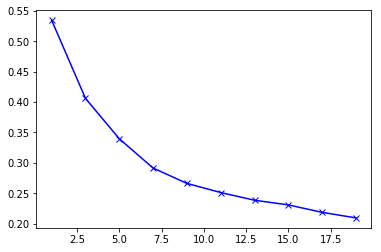

In [312]:
# Consumption clustering for activity group 1
g = Cmpg[0].copy()
K = [i * 2 + 1 for i in range(10)]
errors = []
for j in K:
    kmeans = KMeans(n_clusters = j).fit(g)
    errors.append(sum(np.min(cdist(g, kmeans.cluster_centers_, 'euclidean'), axis=1)) / g.shape[0])
plt.plot(K, errors, 'bx-')

In [316]:
k = 8
errors = [] # Track errors 
rstates = [1,18,42,99,76] # Determine random seed that doesn't fall into a local minimum
for rs in rstates:
    kmeans = KMeans(n_clusters=k, random_state = rs).fit(g)
    errors.append(sum(np.min(cdist(g, kmeans.cluster_centers_, 'euclidean'), axis=1)) / g.shape[0])

In [317]:
[i == np.min(errors) for i in errors] # Choose 42

[False, False, True, False, False]

In [328]:
kmeans = KMeans(n_clusters=k, random_state = 42).fit(g)
clusters = pd.DataFrame(kmeans.cluster_centers_, columns=g.columns)
clusters['Count'] = Cmpg[0].groupby('Group').count().mean(axis=1).values
clusters

Activity,Household heating => 70F,Household heating < 70F,Use of heat pump,Use of air conditioner,Count
0,0.799361,0.246203,0.991367,0.729856,139.0
1,0.571138,0.789295,0.990244,0.801829,164.0
2,0.766493,0.277778,0.995313,0.169531,128.0
3,0.486111,0.607639,0.187500,0.507812,32.0
4,0.212366,0.170251,0.995161,0.250806,124.0
5,0.798611,0.799383,0.997222,0.304167,144.0
6,0.211831,0.321343,0.979856,0.770504,139.0
7,0.196970,0.779461,0.995455,0.287879,132.0


In [319]:
Cmpg[0]['Group'] = kmeans.predict(g)

C:\Users\sc1692.8.29.18\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Activity,Household heating => 70F,Household heating < 70F,Use of heat pump,Use of air conditioner,Group
Indnum,,,,,
1,0.111111,1.000000,1.0,0.40,7
2,0.666667,0.111111,1.0,0.15,2


In [326]:
# Check distribution of clusters
Cmpg[0].groupby('Group').count().mean(axis=1).values

array([139., 164., 128.,  32., 124., 144., 139., 132.])

In [ ]:
# Consumption and QLI clustering by activity group
# TODO

In [ ]:
# TODO: For some activity groups, use Cmp_sources_g (with sources used)
# This would combine people with similar CF and similar sources, which can be used to recommend changes
# Also, can recommend certain changes only to individuals with certain sources and not combine this in the clustering

## Dimension reduction

### Look for multicolinearity

In [66]:
cm = QLI.corr()
mx = []
for i in range(len(QLI.columns)):
    mx.append([QLI.columns[i],0,"",0,""])
    for j in range(len(QLI.columns)):
        if i != j:
            if cm.iloc[i,j] > mx[i][1]:
                mx[i][1] = cm.iloc[i,j]
                mx[i][2] = QLI.columns[j]
            if cm.iloc[i,j] < mx[i][3]:
                mx[i][3] = cm.iloc[i,j]
                mx[i][4] = QLI.columns[j]
                
pd.DataFrame(mx, columns=['Feature', 'mostCorr', 'corrWith', 'negCorr', 'negWith'])

,Feature,mostCorr,corrWith,negCorr,negWith
0,Household heating < 70F,0.057176,use of dishwasher,-0.093584,bags of compost deposited (negative CF)
1,Household heating => 70F,0.042424,car trips - driver and self,-0.326302,air travel - small plane (<50 seats)
2,Small kitchen appliance in the home,0.000000,,0.000000,
3,TV/computer use,0.062943,large items disposed,-0.128648,air travel - small plane (<50 seats)
4,Use of air conditioner,0.241813,bags of recycling deposited (negative CF),-0.080677,air travel - small plane (<50 seats)
5,Use of heat pump,0.106200,bags of compost deposited (negative CF),-0.089047,air travel - small plane (<50 seats)
6,air travel - large plane,0.062911,use of clothes dryer,-0.170115,air travel - small plane (<50 seats)
7,air travel - small plane (<50 seats),1.000000,bags of recycling deposited (negative CF),-0.339552,use of oven
8,bags of compost deposited (negative CF),0.158760,car trips - driver and self,-0.318870,air travel - small plane (<50 seats)
9,bags of garbage disposed,0.055251,air travel - large plane,-0.330708,bags of recycling deposited (negative CF)


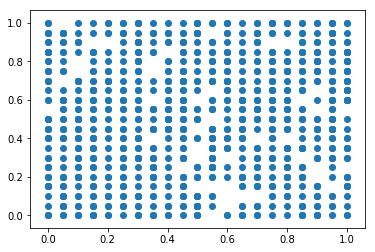

In [67]:
plt.scatter(QLI['trips using public ground transportation'], QLI['shower - long (> 3 min)'])


## Clustering on Cmp and Sources

In [73]:
# Activity group 1, consumption and sources used
csg1 = Cmp_sources_g[0].copy()
# normalize
csg1 = (csg1 - csg1.min()) / (np.abs(csg1.max())- csg1.min())
csg1.drop(['OP_e', 'NG', 'Use of heat pump', 'peak_e'], axis=1, inplace = True)

In [74]:
csg1[:2]

,Household heating < 70F,Household heating => 70F,Use of air conditioner
0,1.000000,0.111111,0.40
1,0.111111,0.666667,0.15


In [98]:
q = QLIg[0].copy()
q.drop('Use of heat pump', axis=1, inplace=True)
q.columns = ["QLI_" + c for c in q.columns]
q = (q - q.min()) / (q.max() - q.min()) # Normalize (0-1 scale)
# add indnum as index to csg1
csg1.index = q.index
qcf1 = csg1.join(q)
qcf1[:2]

,Household heating < 70F,Household heating => 70F,Use of air conditioner,QLI_Household heating < 70F,QLI_Household heating => 70F,QLI_Use of air conditioner
Indnum,,,,,,
1,1.000000,0.111111,0.40,0.757576,0.848485,0.35
2,0.111111,0.666667,0.15,0.030303,0.515152,0.95


In [99]:
# random_state = 18
kmeans = KMeans(n_clusters=6).fit(qcf1)
clusters = pd.DataFrame(kmeans.cluster_centers_, columns=qcf1.columns)
clusters

,Household heating < 70F,Household heating => 70F,Use of air conditioner,QLI_Household heating < 70F,QLI_Household heating => 70F,QLI_Use of air conditioner
0,0.575937,0.626561,0.717751,0.315044,0.225211,0.370118
1,0.282764,0.799145,0.232051,0.504468,0.555361,0.386538
2,0.443196,0.531211,0.819944,0.629213,0.742424,0.587921
3,0.197531,0.197531,0.388333,0.509428,0.425253,0.590000
4,0.761183,0.293651,0.368182,0.365211,0.659976,0.299026
5,0.783838,0.662626,0.368788,0.707438,0.393388,0.720303


In [100]:
kmeans.labels_

array([4, 1, 3, ..., 2, 3, 3])

In [101]:
qcf1[0:1]

,Household heating < 70F,Household heating => 70F,Use of air conditioner,QLI_Household heating < 70F,QLI_Household heating => 70F,QLI_Use of air conditioner
Indnum,,,,,,
1,1.0,0.111111,0.4,0.757576,0.848485,0.35
